In [81]:
import numpy as np
import pandas as pd
import os
import mne
import matplotlib.pyplot as plt

%matplotlib qt

In [82]:
def deduplicate_responses(trial):
    """Remove duplicate 3 and 4 triggers (button presses), keep first occurrence."""
    clean_array = []
    seen = set()
    duplicates = []


    for row in trial:
        code = row[2]
        if code in (3, 4):
            if code in seen:
                duplicates.append(row)
                continue
            seen.add(code)
        clean_array.append(row)

    return np.array(clean_array), np.array(duplicates) if duplicates else None

In [83]:
def classify_trial(trial):
    """Classify a trial as 'go', 'stop', or 'bad' based on event codes."""
    # Extract event codes
    codes = trial[:, 2].tolist()

    # Must start and end correctly
    if codes[0] != 1 or codes[-1] != 6:
        return 'bad'

    # Required onset
    if 2 not in codes:
        return 'bad'

    # Enforce order: 1 < 2 < 6
    i1 = codes.index(1)
    i2 = codes.index(2)
    i6 = len(codes) - 1
    if not (i1 < i2 < i6):
        return 'bad'

    has_stop = 5 in codes
    has_3 = 3 in codes
    has_4 = 4 in codes

    # Count occurrences
    n3 = codes.count(3)
    n4 = codes.count(4)
    n5 = codes.count(5)

    # ---------- GO TRIAL ----------
    # 1 - 2 - 3 & 4 (any order) - 6
    if not has_stop:
        if has_3 and has_4 and n3 == 1 and n4 == 1:
            return 'go'
        else:
            return 'bad'

    # ---------- STOP TRIAL ----------
    # 1 - 2 - 5 - 6 (no responses)
    if has_stop:
        if n5 == 1 and not has_3 and not has_4:
            return 'stop'
        else:
            return 'bad'


# ARI

In [84]:
eeg_path = "C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\eeg"
eeg_file_name = "test_AM_07_ARI.vhdr"
raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
raw.info

Extracting parameters from C:\Users\a1902989\Box\Katya\# PD project\pilot\eeg\test_AM_07_ARI.vhdr...
Setting channel info structure...
Reading 0 ... 794029  =      0.000 ...  1588.058 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_14564\1969921993.py:3: RuntimeWarning: No coordinate information found for channels ['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_14564\1969921993.py:3: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG, 5 misc
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 131.0 Hz
 meas_date: 2026-01-14 15:03:51 UTC
 nchan: 69
 projs: []
 sfreq: 500.0 Hz
>

**Prep for epoching: Read events and annotate bad trials**

In [85]:
# 1 = trial start (empty bars appear)
# 2 = trial onset (bar starts filling)
# 3 = left response
# 4 = right response
# 5 = stop signal presentation
# 6 = trial end (prior to ITI)

# 19 = go only practice
# 20 = go/stop practice
# 21:n trials+20 = training blocks

events_dict = mne.events_from_annotations(raw)[1]
events = mne.events_from_annotations(raw)[0]
events_dict

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S 19'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25'), np.str_('Stimulus/S 26'), np.str_('Stimulus/S 27'), np.str_('Stimulus/S 28'), np.str_('Stimulus/S 29'), np.str_('Stimulus/S 30'), np.str_('Stimulus/S 31'), np.str_('Stimulus/S 32')]
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S 19'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25'), np.str_('Stimulus/S 26'), np.str_('Stimulus/S 27'), np.str_('Stimulus/S 28'), 

{np.str_('Stimulus/S  1'): 1,
 np.str_('Stimulus/S  2'): 2,
 np.str_('Stimulus/S  3'): 3,
 np.str_('Stimulus/S  4'): 4,
 np.str_('Stimulus/S  5'): 5,
 np.str_('Stimulus/S  6'): 6,
 np.str_('Stimulus/S 19'): 19,
 np.str_('Stimulus/S 20'): 20,
 np.str_('Stimulus/S 21'): 21,
 np.str_('Stimulus/S 22'): 22,
 np.str_('Stimulus/S 23'): 23,
 np.str_('Stimulus/S 24'): 24,
 np.str_('Stimulus/S 25'): 25,
 np.str_('Stimulus/S 26'): 26,
 np.str_('Stimulus/S 27'): 27,
 np.str_('Stimulus/S 28'): 28,
 np.str_('Stimulus/S 29'): 29,
 np.str_('Stimulus/S 30'): 30,
 np.str_('Stimulus/S 31'): 31,
 np.str_('Stimulus/S 32'): 32}

In [86]:
starts = np.where(events[:, 2] == 1)[0]
ends   = np.where(events[:, 2] == 6)[0]

assert len(starts) == len(ends), "Unmatched trial start/end triggers"

trial_events = []

for s, e in zip(starts, ends):
    trial_events.append(events[s:e+1])

In [87]:
# Deduplicate key responses and classify trials
clean_trials = [deduplicate_responses(t)[0] for t in trial_events]
duplicates = [deduplicate_responses(t)[1] for t in trial_events if deduplicate_responses(t)[1] is not None]
events_clean = events.copy()
for dup in duplicates:
    events_clean = events_clean[~np.all(events_clean == dup, axis=1)]

labels = [classify_trial(t) for t in clean_trials]

good_go   = [t for t, l in zip(clean_trials, labels) if l == 'go']
good_stop = [t for t, l in zip(clean_trials, labels) if l == 'stop']
bad       = [t for t, l in zip(clean_trials, labels) if l == 'bad']

print(f"Go trials   : {len(good_go)}")
print(f"Stop trials : {len(good_stop)}")
print(f"Bad trials  : {len(bad)}")

Go trials   : 276
Stop trials : 50
Bad trials  : 110


In [ ]:
# Setting up annotations for bad trials: based on behavioral performance
sfreq = raw.info['sfreq']

onsets = []
durations = []
descriptions = []

for trial in bad:
    start_samp = trial[0, 0]
    end_samp   = trial[-1, 0]

    onsets.append(start_samp / sfreq)
    durations.append((end_samp - start_samp) / sfreq)
    descriptions.append('BAD')
bad_annots = mne.Annotations(onsets, durations, descriptions)

# Remove existing annotations (events are stored as np.array) and set new ones
raw.set_annotations(None)
raw.set_annotations(bad_annots)
# raw.plot(events=events_clean)


**Define timing and events for epoching**

In [27]:
# ITI go
print((good_go[1][0][0] - good_go[0][3][0]) / 500)
print((good_go[2][0][0] - good_go[1][3][0]) / 500)

# ITI stop
print((good_stop[1][0][0] - good_stop[0][3][0]) / 500)
print((good_stop[2][0][0] - good_stop[1][3][0]) / 500)

4.632
7.754
22.158
1.01


In [89]:
iti_go = []
for i in range(len(good_go)-1):
    iti_go.append((good_go[i+1][0][0] - good_go[i][3][0]) / 500)
print(min(iti_go)) # 1s

iti_stop = []
for i in range(len(good_stop)-1):
    iti_stop.append((good_stop[i+1][0][0] - good_stop[i][3][0]) / 500)
print(min(iti_stop)) # 1s

1.394
1.01


In [ ]:
sfreq = raw.info['sfreq']

starts = events[events[:, 2] == 1][:, 0]
onsets = events[events[:, 2] == 2][:, 0]
stops = events[events[:, 2] == 5][:, 0]
ends = events[events[:, 2] == 6][:, 0]

n_trials = len(starts)

timing = pd.DataFrame({
    'start_to_onset': (onsets - starts) / sfreq,
    'start_to_end': (ends - starts) / sfreq
})
timing.describe()

,start_to_onset,start_to_end,end_to_start_next
count,436.000000,436.000000,435.000000
mean,0.741789,2.016252,1.346602
std,0.147759,0.148008,2.952934
min,0.496000,1.772000,0.990000
25%,0.613500,1.888000,1.014000
50%,0.735000,2.008000,1.014000
75%,0.870000,2.149000,1.014000
max,1.000000,2.278000,49.434000


In [ ]:
# Calculate inter-trial intervals (ITI)
intervals = np.append(np.where((starts[1:] - ends[:-1]) / sfreq <= 2,
                                (starts[1:] - ends[:-1]) / sfreq,
                                np.nan),
                      np.nan)
pd.Series(intervals).describe()


count    422.000000
mean       1.013659
std        0.001589
min        0.990000
25%        1.014000
50%        1.014000
75%        1.014000
max        1.018000
dtype: float64

STOPPED HERE

In [99]:
events

array([[ 54373,      0,     19],
       [ 54378,      0,      1],
       [ 54692,      0,      2],
       ...,
       [786582,      0,      4],
       [786586,      0,      3],
       [786807,      0,      6]], shape=(2123, 3))

In [100]:
good_stop

[array([[107977,      0,      1],
        [108448,      0,      2],
        [108686,      0,      5],
        [109085,      0,      6]]),
 array([[120164,      0,      1],
        [120426,      0,      2],
        [120664,      0,      5],
        [121065,      0,      6]]),
 array([[121570,      0,      1],
        [121842,      0,      2],
        [122094,      0,      5],
        [122480,      0,      6]]),
 array([[122987,      0,      1],
        [123240,      0,      2],
        [123504,      0,      5],
        [123879,      0,      6]]),
 array([[142634,      0,      1],
        [142972,      0,      2],
        [143235,      0,      5],
        [143610,      0,      6]]),
 array([[161025,      0,      1],
        [161515,      0,      2],
        [161793,      0,      5],
        [162154,      0,      6]]),
 array([[162661,      0,      1],
        [163101,      0,      2],
        [163390,      0,      5],
        [163737,      0,      6]]),
 array([[167226,      0,      1],


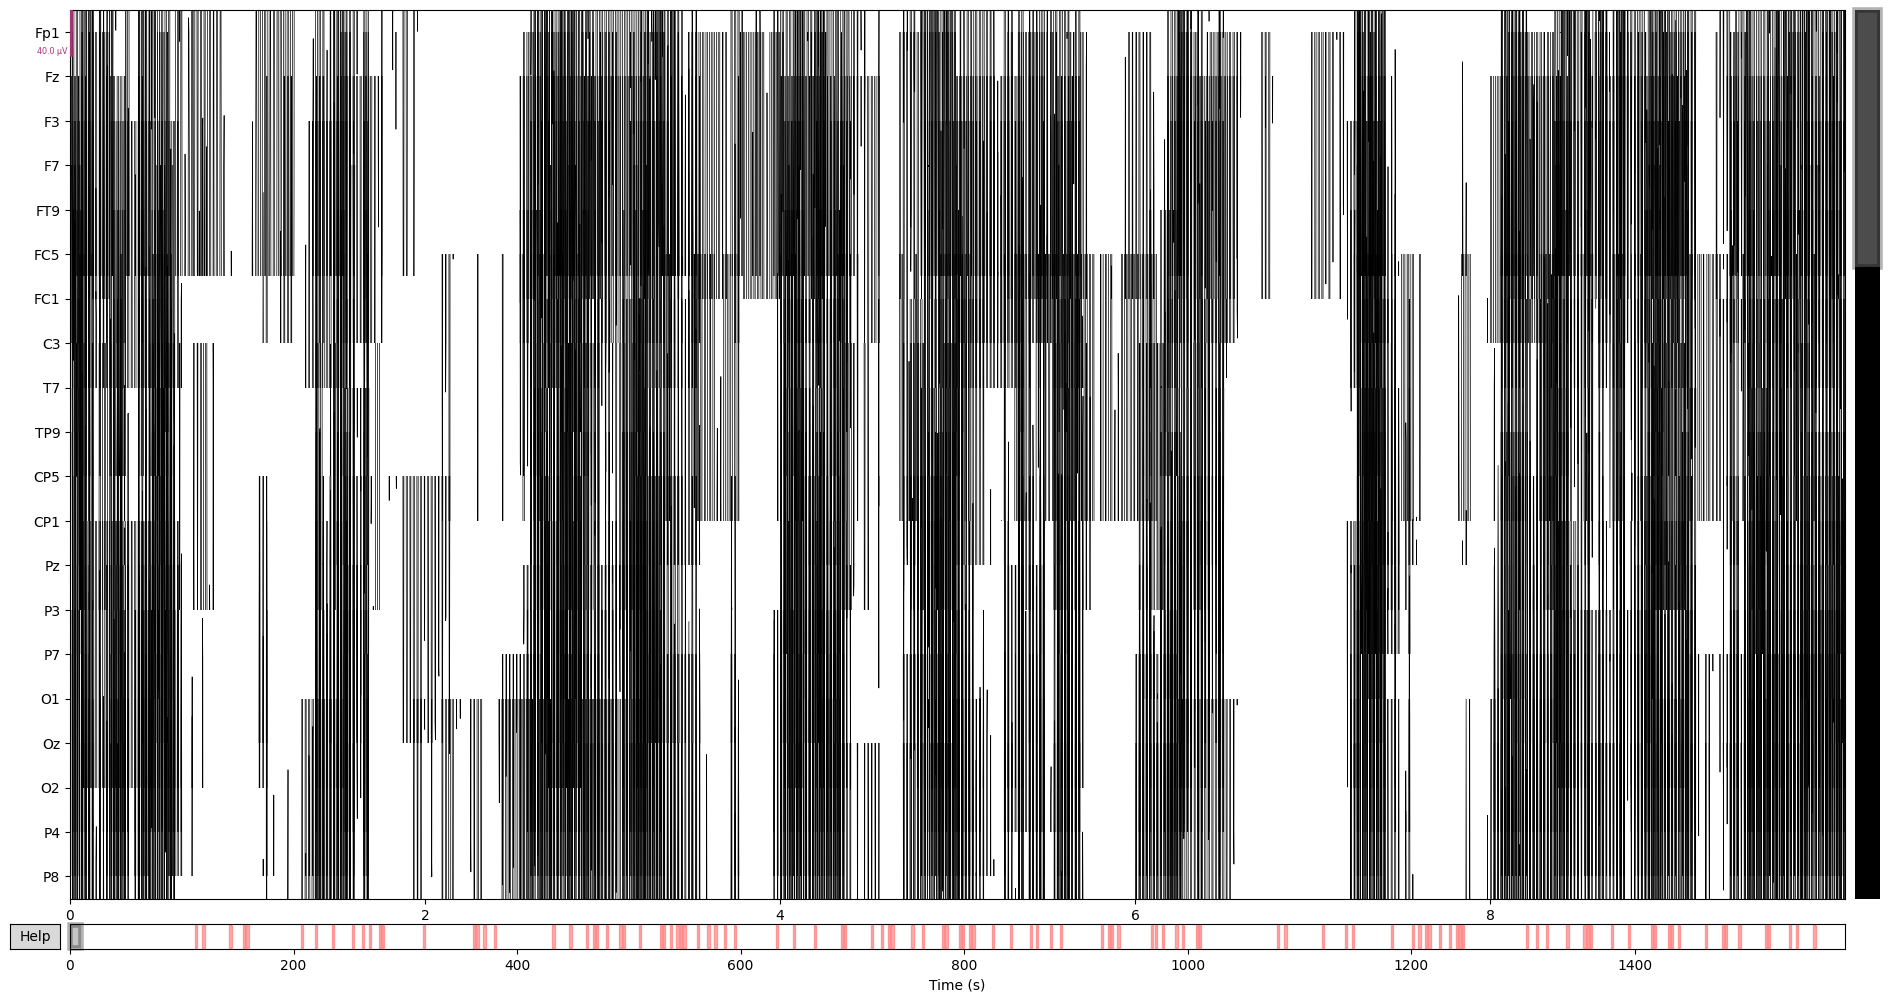

In [102]:
raw.plot(events=events_clean)

In [101]:
rows = []

for trial in good_stop:
    samp_2 = trial[trial[:, 2] == 2][0, 0]   # onset
    samp_5 = trial[trial[:, 2] == 5][0, 0]   # stop
    samp_6 = trial[trial[:, 2] == 6][0, 0]   # end

    rows.append({
        'onset_to_stop': (samp_5 - samp_2) / sfreq,
        'stop_to_end': (samp_6 - samp_5) / sfreq,
        'onset_to_end': (samp_6 - samp_2) / sfreq,
    })

stop_timing = pd.DataFrame(rows)
stop_timing.describe()


,onset_to_stop,stop_to_end,onset_to_end
count,50.000000,50.000000,50.000000
mean,0.596800,0.678040,1.274840
std,0.038651,0.038999,0.002179
min,0.476000,0.624000,1.270000
25%,0.580000,0.646000,1.274000
50%,0.602000,0.672000,1.276000
75%,0.626000,0.694000,1.276000
max,0.654000,0.802000,1.278000


In [ ]:
# parameters for epoching
metadata_tmin, metadata_tmax = -0.5, 1 # [-0.5, 1]
# events of interest
row_events = ['5'] # stop signal

# timing of the epochs
epochs_tmin, epochs_tmax = -0.5, 0.5  # epochs range: [-0.5, 5] for _go or [-0.5, 0.5] for _plan

baseline_epo = (epochs_tmin, 0) # baseline is the average of the epoch


sf = raw.info['sfreq'] # sampling frequency of data

# Open events from pickle file
# with open(os.path.join(filt_dir, f'{sub_name}{task}_events.pkl'), 'rb') as pickle_file:
#     events = pickle.load(pickle_file)

# auto-create metadata:
# this also returns a new events array and an event_id dictionary. we'll see
# later why this is important
metadata, events, event_id = mne.epochs.make_metadata(
    events=events[0],
    event_id=events[1],
    tmin=metadata_tmin,
    tmax=metadata_tmax,
    sfreq=raw.info["sfreq"],
    row_events=row_events
)

epochs = mne.Epochs(
    raw=raw,
    tmin=epochs_tmin,
    tmax=epochs_tmax,
    events=events,
    event_id=event_id,
    baseline=baseline_epo,
    metadata=metadata,
    reject_by_annotation=True,
    preload=True,
)
